In [1]:
from dataclasses import dataclass

import geometry as geo
import gym_duckietown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from gym_duckietown.simulator import Simulator
from IPython import display as ipythondisplay

from utils import get_position, my_odom_lin, Position, my_odometry, auto_odom_lin_full

DEBUG:commons:version: 6.2.4 *
DEBUG:typing:version: 6.2.3
DEBUG:geometry:PyGeometry-z6 version 2.1.4 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:duckietown_world:duckietown-world version 6.2.38 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:aido_schemas:aido-protocols version 6.0.59 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:nodes:version 6.2.13 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages pyparsing 3.0.6
DEBUG:gym-duckietown:gym-duckietown version 6.1.30 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages



{'audio': ('xaudio2', 'directsound', 'openal', 'pulse', 'silent'), 'debug_font': False, 'debug_gl': True, 'debug_gl_trace': False, 'debug_gl_trace_args': False, 'debug_graphics_batch': False, 'debug_lib': False, 'debug_media': False, 'debug_texture': False, 'debug_trace': False, 'debug_trace_args': False, 'debug_trace_depth': 1, 'debug_trace_flush': True, 'debug_win32': False, 'debug_x11': False, 'graphics_vbo': True, 'shadow_window': True, 'vsync': None, 'xsync': True, 'xlib_fullscreen_override_redirect': False, 'darwin_cocoa': True, 'search_local_libs': True, 'advanced_font_features': False, 'headless': False, 'headless_device': 0}


In [2]:
plt.rcParams['figure.figsize'] = [7, 7]

In [3]:
#gym_duckietown is very chatty
import logging
gym_duckietown.logger.setLevel(logging.WARNING)

In [4]:
env = Simulator("small_loop",
    full_transparency=True,
    domain_rand=False,
    user_tile_start=[1,0],
    seed=42,
    max_steps=float("inf"),
)

INFO:duckietown_world: data: /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages/duckietown_world/data


In [5]:
env.unwrapped.start_pose = [[0.11699990272521976, 0, 0.41029359288296474], 0]

In [6]:
env.reset()
for _ in range(100):
    obs, reward, done, info = env.step([1,1])
    if done:
        break
    print(info["Simulator"]["robot_speed"])

0.0
0.0
0.0
0.0
0.09999999999999898
0.18333333333333202
0.25277777777777843
0.31064814814814823
0.35887345679012306
0.3990612139917682
0.4325510116598086
0.46045917638317224
0.4837159803193125
0.5030966502660916
0.5192472085550759
0.53270600712923
0.5439216726076912
0.5532680605064111
0.5610567170886738
0.5675472642405621
0.5729560535338007
0.5774633779448346
0.5812194816206973
0.584349568017245
0.5869579733477037
0.5891316444564243
0.5909430370470203
0.5924525308725159
0.5937104423937622
0.5947587019948042
0.5956322516623325
0.5963602097186138
0.596966841432176
0.5974723678601479
0.5978936398834533
0.5982446999028812
0.5985372499190666
0.5987810415992234
0.5989842013326863
0.5991535011105698
0.5992945842588071
0.5994121535490105
0.5995101279575032
0.599591773297925
0.5996598110815987
0.5997165092346712
0.599763757695555
0.5998031314129615
0.5998359428441336
0.5998632857034503
0.5998860714195375
0.5999050595162858
0.5999208829302383
0.5999340691085275
0.5999450575904386
0.5999542146587

In [7]:
delta_time = 1.0 / env.frame_rate

https://drive.google.com/file/d/19U1DUo3GtqHxncEKLn2d6RRdLTLgD0Bv/view

In [8]:
u1 = 5
u2 = 0
u3 = 0
w1 = 4
w2 = 0
w3 = 0
# parameters for forced dynamics
uar = 1.5
ual = 1.5
war = 15  # modify this for trim
wal = 15

u_alpha_r = uar
u_alpha_l = ual
w_alpha_r = war
w_alpha_l = wal

In [9]:
R = 0.067 / 2  # 6.7 cm diameter
D = 0.102

In [10]:
def get_acceleration(action, u=None, w=None):
    """
    Second derivative of x
    xdotdot[0] = acc longitudinal
    xdotdot[1] = acc angular
    """
    # https://drive.google.com/file/d/19U1DUo3GtqHxncEKLn2d6RRdLTLgD0Bv/view
    # Paragraph 5.1.5
    
    # wr, wl
    U = np.array([action[1], action[0]])
    V = U.reshape(U.size, 1)
    V = np.clip(V, -1, +1)

    # Previous step linear and angular speed
    # u, w = longit_prev, angular_prev

    ## Calculate Dynamics
    # nonlinear Dynamics - autonomous response
    f_dynamic = np.array([[-u1 * u - u2 * w + u3 * w ** 2], [-w1 * w - w2 * u - w3 * u * w]])  #
    # input Matrix
    B = np.array([[u_alpha_r, u_alpha_l], [w_alpha_r, -w_alpha_l]])
    # forced response
    f_forced = np.matmul(B, V)
    # acceleration
    x_dot_dot = f_dynamic + f_forced
    return x_dot_dot

In [11]:
def myodom(action, x0, y0, theta0, v0=0, w0=0, dt=0.033):
    x_dot_dot, w_dot_dot = get_acceleration(action, u=v0, w=w0)

    v1 = v0 + x_dot_dot[0]*dt
    w1 = w0 + w_dot_dot[0]*dt

    # Runge Kutta
    x1 = x0 + v0*dt*np.cos(theta0 + w0*dt/2)
    y1 = y0 + v0*dt*np.sin(theta0 + w0*dt/2)
    theta1 = theta0 + w0*dt

    return Position(x1, y1, theta1), v1, w1

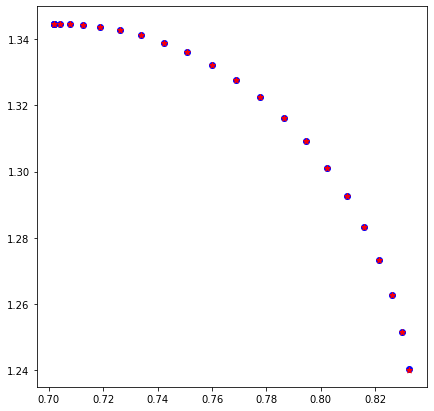

Collision


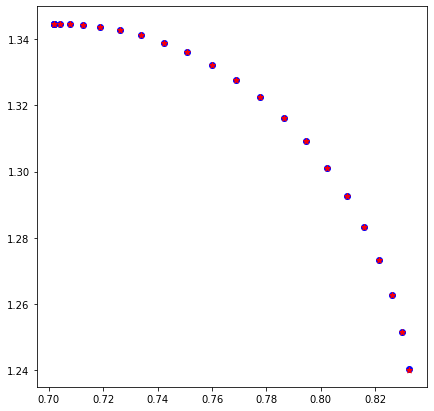

In [29]:
env.reset()
pose = get_position(env)
delay = round(0.15/delta_time)
actions = []
odoms = [pose]
odoms_l = [pose]
poses = []
v_1 = 0
w_1 = 0
v0 = 0
w0 = 0
v = [0,0]
real_v = []
w = [0,0]
# plt.imshow(np.flip(env.render(mode="top_down"), [0]))
for i in range(50):
    action = [1,0.2]
    actions.append(action)
    obs, reward, done, info = env.step(action)
    if reward == -1000:
        print("Collision")
        break
    # Test odometry
    real_v.append(info["Simulator"]["robot_speed"])
    if len(actions) < delay+1:
        # p_l  = my_odom_lin(v0, w0, odoms_l[-1].x, odoms_l[-1].y, odoms_l[-1].theta, dt=delta_time, v_eq=v_1, w_eq=w_1)
        # v0, w0 = v_1, w_1
        p, v0, w0 = auto_odom_lin_full([0,0], odoms[-1].x, odoms[-1].y, odoms[-1].theta, v0=v0, w0=w0, dt=delta_time)
    else:
        # p_l = my_odom_lin(v0, w0, odoms_l[-1].x, odoms_l[-1].y, odoms_l[-1].theta, dt=delta_time, v_eq=v_1, w_eq=w_1)
        # v0, w0 = v_1, w_1
        p, v0, w0 = auto_odom_lin_full(action, odoms[-1].x, odoms[-1].y, odoms[-1].theta, v0=v0, w0=w0, dt=delta_time)
    # p_l = Position(p_l[0], p_l[1], p_l[2])
    v.append(v0)
    w.append(w0)
    odoms.append(p)
    # odoms_l.append(p_l)
    try:
        pose = get_position(env)
    except ValueError:
        print(env.cartesian_from_weird(env.cur_pos, env.cur_angle))
        break
    poses.append(pose)
    # print(loss(np.array([0,1]*int(horizon_len/2)).reshape(-1), pose, traj, index))
    plt.scatter(pose.x, pose.y, marker="o", c="b")
    # Test odometry
    o = get_position(env)
    # plt.scatter(o.x, o.y, marker="*", c="r")
    plt.scatter(p.x, p.y, marker="*", c="r")
    # Linearized odometry
    # plt.scatter(p_l.x, p_l.y, marker="^", c="g")
    # plt.imshow(obs)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

In [20]:
pd.DataFrame(odoms)

,x,y,theta
0,0.702000,1.344706,0.000000
1,0.702000,1.344706,0.000000
2,0.702000,1.344706,0.000000
3,0.702000,1.344706,0.000000
4,0.704000,1.344693,-0.013333
5,0.707665,1.344599,-0.038222
6,0.712713,1.344317,-0.073126
7,0.718898,1.343728,-0.116709
8,0.726003,1.342711,-0.167815
9,0.733830,1.341152,-0.225439


In [24]:
pd.DataFrame(poses)

,x,y,theta
0,0.702000,1.344706,0.0
1,0.702000,1.344706,0.0
2,0.702000,1.344706,0.0
3,0.702000,1.344706,0.0
4,0.704000,1.344693,-0.8
5,0.707665,1.344599,-2.2
6,0.712713,1.344317,-4.2
7,0.718897,1.343728,-6.7
8,0.726001,1.342711,-9.6
9,0.733828,1.341152,-12.9
